In [1]:
class FloatIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2):
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.a1 = a1
        self.a2 = a2
        # 初始化存储过去的值, y1 y2为高bit的值
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
    
    def process(self, x):
        # 计算当前输出
        y = (self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - 
             self.a1 * self.y1 - self.a2 * self.y2)

        # 更新历史值
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

In [2]:
import numpy as np
from scipy.signal import butter
class QuantizedIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2, coeff_left_shift_bits=26, output_dec_bits=24, feedback_half_lsb=False):
        # 系数量化
        self.left_scale = 2 ** coeff_left_shift_bits
        # 存储量化因子
        self.output_dec_bits = output_dec_bits
        self.b0 = np.round((1 - b0) * self.left_scale)
        self.b1 = np.round((2 + b1) * self.left_scale)
        self.b2 = np.round((1 - b2) * self.left_scale)
        self.a1 = np.round((2 + a1) * self.left_scale)
        self.a2 = np.round((1 - a2) * self.left_scale)
        # print(self.left_scale)
        # print(self.output_dec_bits)
        print(self.b0, self.b1, self.b2, self.a1, self.a2)
        print((1 - b0) * self.left_scale, (2 + b1) * self.left_scale, (1 - b2) * self.left_scale, (2 + a1) * self.left_scale, (1 - a2) * self.left_scale)


        # 初始化历史变量，使用double精度
        self.x1 = np.float64(0)
        self.x2 = np.float64(0)
        self.y1 = np.float64(0)
        self.y2 = np.float64(0)

        

    def process(self, x):

        # 反馈部分计算
        accumuator = 0
        accumuator = (x - 2*self.x1 + self.x2)* 2**self.output_dec_bits + 2 * self.y1 - self.y2
        accu_ay = (-self.a1*self.y1 + self.a2*self.y2)
        accu_bx = (-self.b0*x + self.b1*self.x1 - self.b2*self.x2) * 2**self.output_dec_bits
        # add extra 0.5 lsb bias
        # accumuator = accumuator + np.floor((accu_bx + accu_ay) / self.left_scale)
        accumuator = accumuator + np.floor((accu_bx + accu_ay + self.left_scale/2) / self.left_scale)

        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = accumuator
        accumuator = np.floor(accumuator  / 2**self.output_dec_bits)
        return accumuator

In [3]:
def signal_generator(fs, time, signal_range, start_freq, end_freq, offset=1000):
    """
    生成一个持续仿真时间的每秒频率递增的正弦波信号。
    参数：
    fs - 每秒采样点数
    time - 仿真时间（秒）
    signal_range - 信号幅度范围
    start_freq - 起始频率(Hz)
    end_freq - 终止频率(Hz)
    
    返回：
    generated_signal - 生成的信号
    """
    num_samples = fs * time  # 总样本数
    t = np.linspace(0, time, num_samples, endpoint=False)  # 时间序列
    generated_signal = np.zeros_like(t)  # 初始化信号数组

    # 逐秒递增频率，生成正弦波信号
    for i in range(time):
        freq = start_freq + i * (end_freq - start_freq) / time
        samples_per_cycle = fs / freq  # 每个周期的样本数
        num_cycles = int(fs // samples_per_cycle)  # 每秒能容纳的完整周期数

        if num_cycles >= 1:
            cycle_samples = int(num_cycles * samples_per_cycle)  # 完整周期的样本数
            t_segment = np.linspace(0, cycle_samples / fs, cycle_samples, endpoint=False)  # 当前段的时间序列
            sine_segment = np.sin(2 * np.pi * freq * t_segment)  # 生成当前频率的正弦波
            generated_signal[i * fs : i * fs + cycle_samples] = np.round(sine_segment * signal_range)  # 插入信号
            # 添加偏移量
            generated_signal[i * fs : i * fs + cycle_samples] += offset

    return generated_signal

In [4]:
import matplotlib.pyplot as plt
start_freq = 2      # 起始频率
end_freq = 2     # 终止频率 2500
fs = 10000  # 每秒采样点数
time = 100  # 仿真时间
signal_range = 500

generated_signal = signal_generator(fs, time, signal_range, start_freq, end_freq)

fc_fs = 2.34777000e-06 # 2.44276000e-06 # 3.60216000e-06  # 2.33100000e-06
b,a = butter(2, 2 * fc_fs, btype="high")
quantized_hpf = QuantizedIIRFilter(b[0], b[1], b[2], a[1], a[2])

scale = 1 / 2**26
# b = np.round(b / scale) * scale
# a = np.round(a / scale) * scale
float_hpf = FloatIIRFilter(b[0], b[1], b[2], a[1], a[2])

y_quantized_hpf = np.array([quantized_hpf.process(sample) for sample in generated_signal])
y_float_hpf = np.array([float_hpf.process(sample) for sample in generated_signal])


700.0 1400.0 700.0 1400.0 1400.0
700.0000025779009 1400.0000051558018 700.0000025779009 1400.007306754589 1399.992703616619


err 263.12954552718213


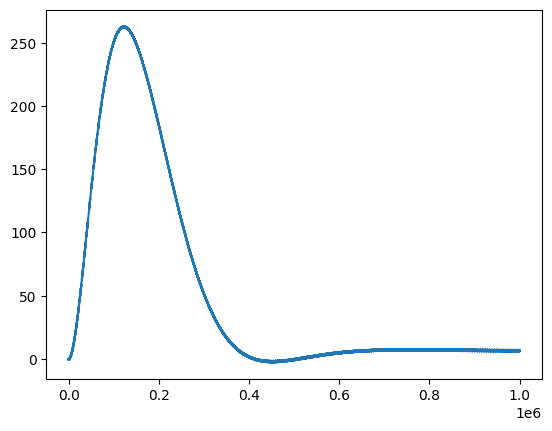

In [5]:
delta = y_quantized_hpf - y_float_hpf
# plt.plot(y_float_hpf)
# plt.plot(y_quantized_hpf)
plt.plot(delta)
# print(delta[:1000])
print("err", np.max(np.abs(delta)))



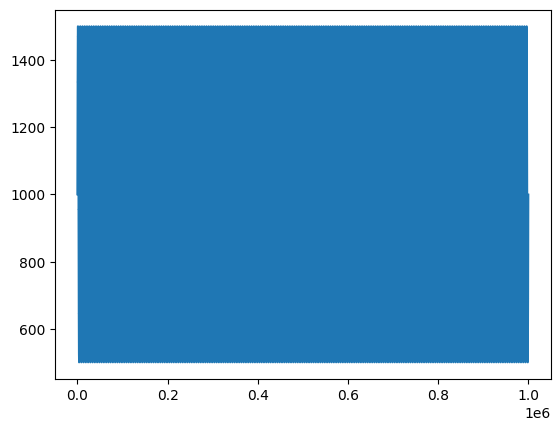

In [6]:
plt.plot(generated_signal)

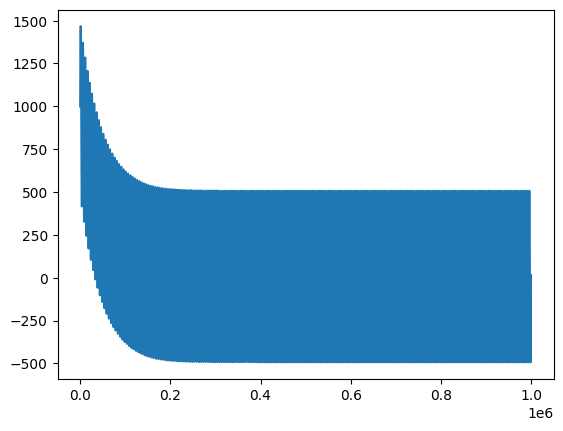

In [7]:
plt.plot(y_quantized_hpf)

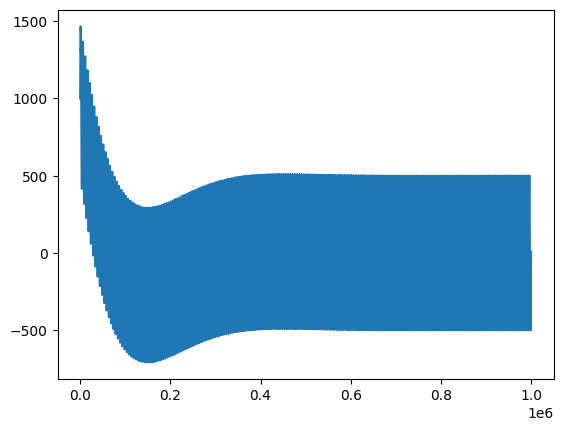

In [8]:
plt.plot(y_float_hpf)

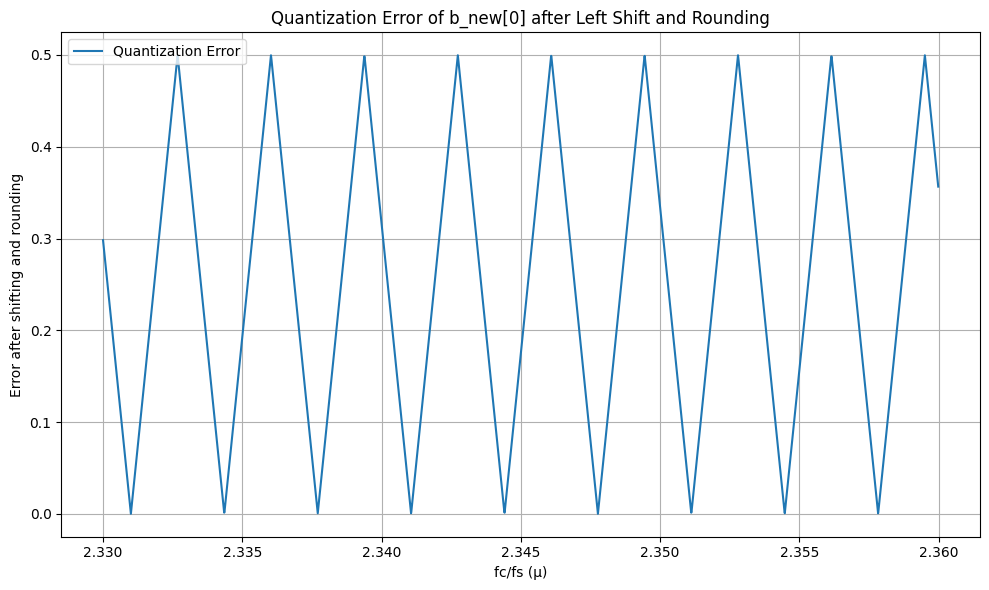

误差最小的前10个点:
 1: fc/fs = 2.34777000e-06, 误差 = 2.57790089e-06
 2: fc/fs = 2.33100000e-06, 误差 = 3.54349613e-05
 3: fc/fs = 2.35783000e-06, 误差 = 5.71094453e-04
 4: fc/fs = 2.33771000e-06, 误差 = 5.76153398e-04
 5: fc/fs = 2.34106000e-06, 误差 = 6.08861446e-04
 6: fc/fs = 2.35448000e-06, 误差 = 6.14017248e-04
 7: fc/fs = 2.35112000e-06, 误差 = 1.18247420e-03
 8: fc/fs = 2.34442000e-06, 误差 = 1.18765980e-03
 9: fc/fs = 2.33435000e-06, 误差 = 1.22039765e-03
10: fc/fs = 2.33436000e-06, 误差 = 1.76114589e-03


In [9]:
# 2e-6 ~ 64e-6
fc_fs_values = np.arange(2.33e-6,2.35e-6 + 0.01e-6, 0.00001e-6)
left_shift = 26
errors = []

for fc_fs in fc_fs_values:
    # 设计高通滤波器
    b, a = butter(2, 2 * fc_fs, btype="high")
    
    # 重新计算 b_new 和 a_new
    b_new = [1 - b[0], 2 + b[1], 1 - b[2]]
    a_new = [1 - a[0], 2 + a[1], 1 - a[2]]
    
    # 左移位转换并计算误差
    scaled_b0 = b_new[0] * (2 ** left_shift)
    rounded_b0 = np.round(scaled_b0)
    error = np.abs(rounded_b0 - scaled_b0)
    errors.append(error)

plt.figure(figsize=(10, 6))
plt.plot(fc_fs_values * 1e6, errors, label="Quantization Error")
plt.xlabel("fc/fs (μ)")
plt.ylabel("Error after shifting and rounding")
plt.title("Quantization Error of b_new[0] after Left Shift and Rounding")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

fc_fs_error_pairs = list(zip(fc_fs_values, errors))
sorted_pairs = sorted(fc_fs_error_pairs, key=lambda x: x[1])

# 打印误差最小的前10个点
print("误差最小的前10个点:")
for i, (fc, err) in enumerate(sorted_pairs[:10]):
    print(f"{i+1:2d}: fc/fs = {fc:.8e}, 误差 = {err:.8e}")

In [10]:
# # fir test, but fail
# from scipy.signal import firwin, freqz
# import numpy as np
# import matplotlib.pyplot as plt

# # 参数设置
# fs = 10000             # 采样频率
# fc = 0.01               # 截止频率（Hz），想滤除更低频段
# numtaps = 10001         # 滤波器阶数 + 1（必须是奇数才能实现对称型线性相位 FIR）

# # FIR高通滤波器设计
# fir_hp = firwin(numtaps=numtaps, cutoff=fc, fs=fs, pass_zero=False)

# # 分析频率响应
# f = np.linspace(0, 10, 2000)  # 分析低频段（0~1Hz）
# w = 2 * np.pi * f / fs
# w, h = freqz(fir_hp, worN=w)

# # 绘图
# plt.plot(f, 20 * np.log10(np.abs(h)))
# plt.title(f'FIR High-pass Filter (fc={fc} Hz, fs={fs} Hz)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude (dB)')
# plt.grid(True)
# plt.show()

In [13]:
# test set up time
from scipy.signal import firwin, freqz
from scipy.signal import butter
import numpy as np
fs = 10000
T = 1 / fs
fc_fs = 32e-6
b, a = butter(2, 2 * fc_fs, btype="high")
# print(1 - b[0])
alpha=0.05
print(b[0], a[1])
time = 2*np.log(alpha/np.abs(b[0])) / np.log(np.abs(a[1]+1)) 
time * T

0.9998578378519752 -1.9997156554938733


np.float64(2.1067150071719194)